# Use structure angle correction with `f3ast`

This notebook shows how we can use as more complicated calibration model that adjust for the angle that the structure grows with respect to GIS.


## Import packages and define microscope settings


In [1]:
import f3ast
import numpy as np

In [2]:
# settings can be loaded from a specified json file (given by file_path="...")
settings = f3ast.load_settings()

file_path = "spiral.stl"
struct = f3ast.Structure.from_file(file_path, **settings["structure"])

# interactive plot for inspection
struct.show()

In [3]:
GR0 = 50e-3  # in um/s, base growth rate
sigma = 4.4  # in nm, dwell size

# simple model, without thermal correction
base_model = f3ast.RRLModel(struct, GR0, sigma)
phi0 = np.deg2rad(135)
correction_factor = 0.1
angle_correction_model = f3ast.PhiAngleCorrectionModel(
    base_model, phi0, correction_factor
)

Slicing...
Sliced


Text(0.5, 1.0, 'Correction factor as a function of angle')

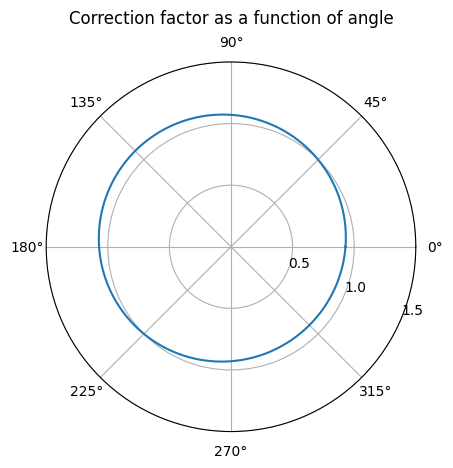

In [4]:
import matplotlib.pyplot as plt

angles = np.linspace(0, 2 * np.pi, 1000)
r = angle_correction_model.angle_correction_function(angles)

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(angles, r)
ax.set_rmax(1.5)
ax.set_rticks([0.5, 1, 1.5])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Correction factor as a function of angle", va="bottom")

Plot angles calculated for each sliced point.


Text(0.5, 0.92, 'Angle of structure at each sliced point')

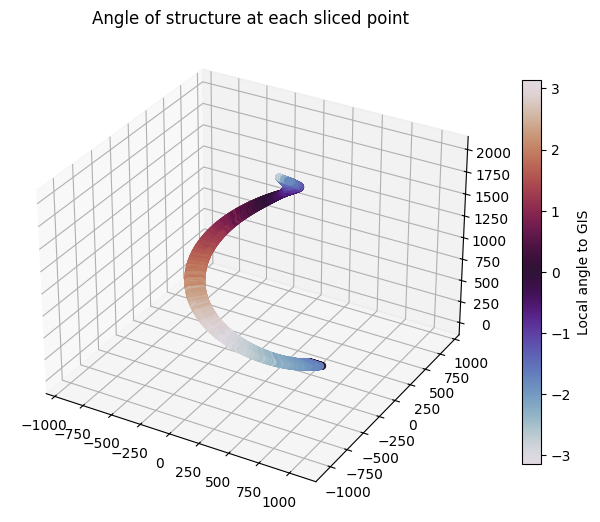

In [5]:
angles_per_sliced_point = np.concatenate(
    [
        ang * np.ones(slice.shape[0])
        for slice, ang in zip(struct.slices, angle_correction_model.layer_angles)
    ]
)
ax, sc = struct.plot_slices(
    c=angles_per_sliced_point, cmap="twilight", colorbar=False)
plt.colorbar(sc, shrink=0.8, label="Local angle to GIS")
plt.title("Angle of structure at each sliced point")

Plot local deposit model correction factor. If the factor is large, this means that the structure is going fast and less dwell time should be spent there. This should be in the direction of the GIS, here defined as 135 deg.


Text(0.5, 0.92, 'Deposit model correction factor')

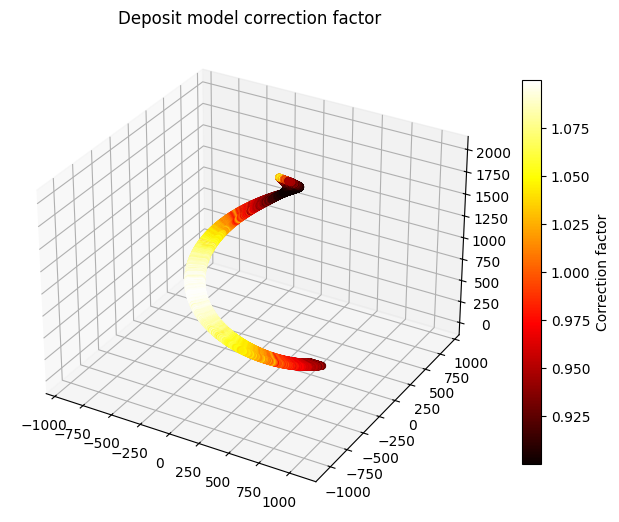

In [6]:
correction_factor_per_sliced_point = angle_correction_model.angle_correction_function(
    angles_per_sliced_point
)
ax, sc = struct.plot_slices(
    c=correction_factor_per_sliced_point, cmap="hot", colorbar=False
)
plt.colorbar(sc, shrink=0.8, label="Correction factor")
plt.title("Deposit model correction factor")

Solving for dwells...
Solved
CPU times: user 1.15 s, sys: 109 ms, total: 1.26 s
Wall time: 11.1 s
Total stream time:  0:07:04.000314


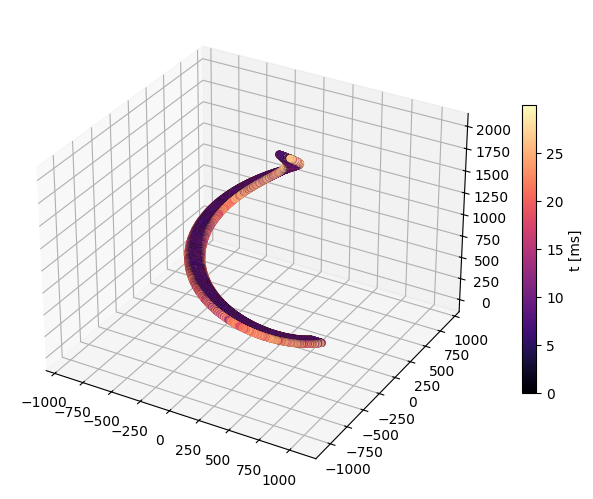

In [7]:
%time stream_builder, dwell_solver = f3ast.StreamBuilder.from_model(angle_correction_model, **settings['stream_builder'])
dwell_solver.print_total_time()

# inspect dwells 
ax, sc = dwell_solver.show_solution()